In [1]:
import sys
sys.path.insert(0, '../')

In [2]:
from attributionpriors.pytorch_ops import AttributionPriorExplainer

In [3]:
from path_explain import PathExplainerTorch

In [4]:
import numpy as np

import matplotlib.pyplot as plt

import torch
from torch.autograd import grad

from torch.utils.data import Dataset, DataLoader

In [5]:
device=torch.device('cuda')

In [6]:
class BinaryData(Dataset):
    def __init__(self, X, y=None, transform=None):
        self.X=X
        self.y=y
        self.transform=transform
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, index):
        sample=self.X[index,:]
        
        if self.transform is not None:
            sample=self.transform(sample)
        
        if self.y is not None:
            return sample, self.y[index]
        else:
            return sample

In [7]:
a_train=torch.empty(1000,1).uniform_(0,1)
x_train=torch.bernoulli(a_train)
x_train=torch.cat([x_train,x_train],axis=1)

In [8]:
a_test=torch.empty(1000,2).uniform_(0,1)
x_test=torch.bernoulli(a_test)

In [9]:
y_train=x_train[:,0]
y_test=x_test[:,0]

In [10]:
train_dataset=BinaryData(x_train, y_train)
train_loader=DataLoader(dataset=train_dataset, batch_size=64, shuffle=True, drop_last=True)

In [11]:
test_dataset=BinaryData(x_test, y_test)
test_loader=DataLoader(dataset=test_dataset, batch_size=64, shuffle=True, drop_last=True)

In [12]:
class MLP(torch.nn.Module):
    def __init__(self):
        super(MLP,self).__init__()
        self.layers=torch.nn.Sequential(torch.nn.Linear(2,1),
                                      torch.nn.Sigmoid())
    def forward(self,x):
        x=self.layers(x)
        return x

In [13]:
def calculate_dependence(model):
    zero_arange=torch.tensor(np.concatenate([np.zeros(100).reshape(-1,1),
                                             np.arange(0,1,0.01).reshape(-1,1)],axis=1)).float().to(device)
    one_arange=torch.tensor(np.concatenate([np.ones(100).reshape(-1,1),
                                             np.arange(0,1,0.01).reshape(-1,1)],axis=1)).float().to(device)


    arange_zero=torch.tensor(np.concatenate([np.arange(0,1,0.01).reshape(-1,1),
                                            np.zeros(100).reshape(-1,1)],axis=1)).float().to(device)
    arange_one=torch.tensor(np.concatenate([np.arange(0,1,0.01).reshape(-1,1),
                                            np.ones(100).reshape(-1,1)],axis=1)).float().to(device)

    dep1=(model(one_arange)-model(zero_arange)).mean().detach().cpu().numpy().reshape(-1)[0]
    dep2=(model(arange_one)-model(arange_zero)).mean().detach().cpu().numpy().reshape(-1)[0]
    
    return dep2/dep1, dep1, dep2

# EG

In [ ]:
convergence_list1_list_eg=[]
convergence_list2_list_eg=[]
convergence_list3_list_eg=[]

for k in [1,2,3,4,5]:

    print('k =',k)
    
    model=MLP().to(device)
    
    with torch.no_grad():
        model.layers[0].weight[0,0]=10
        model.layers[0].weight[0,1]=10
        model.layers[0].bias[0]=-6
        
    x_zeros = torch.zeros_like(x_train[:,0:1])
    background_dataset = BinaryData(x_zeros, y_train)

    APExp = AttributionPriorExplainer(background_dataset, 64, k=k)        
        

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
    bce_term = torch.nn.BCELoss()
    
    train_loss_list_mean_list=[]
    valid_loss_list_mean_list=[]
    
    train_loss_list_mean_best=np.inf
    epoch_best=None
    
    convergence_list1=[]
    convergence_list2=[]
    convergence_list3=[]
        
    for epoch in range(200):
        model.train()
        
        train_loss_list=[]
        
        for i, (X, y) in enumerate(train_loader):
            X, y= X.float().to(device), y.float().to(device)
            optimizer.zero_grad()
            
            output=model(X)
            
            eg=APExp.shap_values(model, X)
            eg_abs_mean=eg.abs().mean(0)
            
            loss=bce_term(output, y) + eg_abs_mean[1].abs()
            
            loss.backward(retain_graph=True)
            optimizer.step()
            train_loss_list.append(loss.item())
        
        train_loss_list_mean=np.mean(train_loss_list)
        
        train_loss_list_mean_list.append(train_loss_list_mean)
        convergence_list1.append(calculate_dependence(model)[0])
        convergence_list2.append(calculate_dependence(model)[1])
        convergence_list3.append(calculate_dependence(model)[2])
        
        if train_loss_list_mean < train_loss_list_mean_best:
            epoch_best=epoch
            train_loss_list_mean_best=train_loss_list_mean
        
    convergence_list1_list_eg.append(convergence_list1)
    convergence_list2_list_eg.append(convergence_list2)
    convergence_list3_list_eg.append(convergence_list3)

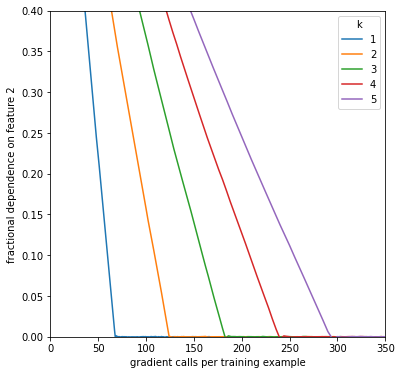

In [29]:
plt.figure(figsize=(6,6))

for k, convergence_list1 in enumerate(convergence_list1_list_eg):
    plt.plot((np.arange(len(convergence_list1))+1)*(k+1), convergence_list1,label=k+1)
    
plt.xlim([0,350])
plt.ylim([0,0.4])
plt.legend(title='k')

plt.xlabel('gradient calls per training example')
plt.ylabel('fractional dependence on feature 2')
plt.show()

# log

In [38]:
model=MLP().to(device)

with torch.no_grad():
    model.layers[0].weight[0,0]=10
    model.layers[0].weight[0,1]=10
    model.layers[0].bias[0]=-6

optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
BCE_term = torch.nn.BCELoss()

train_loss_list_mean_list=[]
valid_loss_list_mean_list=[]

train_loss_list_mean_best=np.inf
epoch_best=None

convergence_list1_log=[]
convergence_list2_log=[]
convergence_list3_log=[]

for epoch in range(200):
    model.train()

    train_loss_list=[]

    for i, (X, y) in enumerate(train_loader):
        X, y= X.float().to(device), y.float().to(device)
        X.requires_grad=True
        
        optimizer.zero_grad()

        output=model(X)

        output_log=torch.log(output)
        X_grad=grad(outputs=output_log, inputs=X, grad_outputs=torch.ones_like(output),
                    create_graph=True)[0]
        ig_abs_mean=X_grad.abs().mean(axis=0)
        
        loss=bce_term(output, y) + ig_abs_mean[1].abs()

        loss.backward(retain_graph=True)
        optimizer.step()
        train_loss_list.append(loss.item())

    train_loss_list_mean=np.mean(train_loss_list)

    train_loss_list_mean_list.append(train_loss_list_mean)
    convergence_list1_log.append(calculate_dependence(model)[0])
    convergence_list2_log.append(calculate_dependence(model)[1])
    convergence_list3_log.append(calculate_dependence(model)[2])

    if train_loss_list_mean < train_loss_list_mean_best:
        epoch_best=epoch
        train_loss_list_mean_best=train_loss_list_mean
    

# 

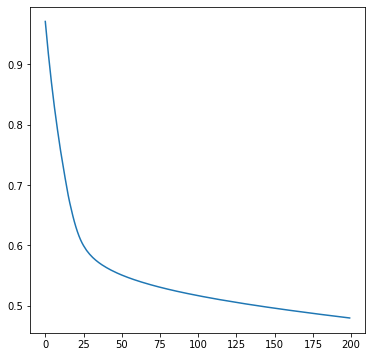

In [37]:
plt.figure(figsize=(6,6))

plt.plot(convergence_list1_log)

plt.show()

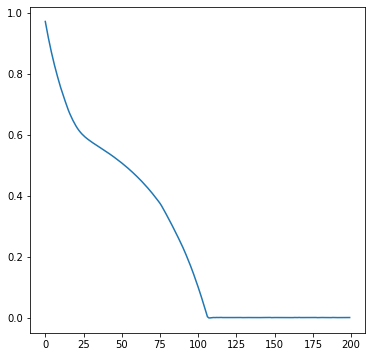

In [34]:
plt.figure(figsize=(6,6))

plt.plot(convergence_list1_log)

plt.show()

In [254]:
X, y= X.float().to(device), y.float().to(device)
X.requires_grad=True

optimizer.zero_grad()

output=model(X)

output_log=torch.log(output)
"""
X_grad=grad(outputs=output_log, inputs=X,
           grad_outputs=torch.ones_like(output),
           )
"""           
output_log.backward(gradient=torch.ones_like(output))

In [248]:
X_grad[0][:2,:2]

tensor([[9.9753e+00, 9.9753e+00],
        [8.3447e-06, 8.3447e-06]], device='cuda:0')

In [255]:
X.grad

tensor([[9.9753e+00, 9.9753e+00],
        [8.3447e-06, 8.3447e-06],
        [9.9753e+00, 9.9753e+00],
        [9.9753e+00, 9.9753e+00],
        [9.9753e+00, 9.9753e+00],
        [8.3447e-06, 8.3447e-06],
        [8.3447e-06, 8.3447e-06],
        [9.9753e+00, 9.9753e+00],
        [9.9753e+00, 9.9753e+00],
        [9.9753e+00, 9.9753e+00],
        [9.9753e+00, 9.9753e+00],
        [8.3447e-06, 8.3447e-06],
        [9.9753e+00, 9.9753e+00],
        [9.9753e+00, 9.9753e+00],
        [8.3447e-06, 8.3447e-06],
        [9.9753e+00, 9.9753e+00],
        [9.9753e+00, 9.9753e+00],
        [8.3447e-06, 8.3447e-06],
        [9.9753e+00, 9.9753e+00],
        [9.9753e+00, 9.9753e+00],
        [8.3447e-06, 8.3447e-06],
        [9.9753e+00, 9.9753e+00],
        [8.3447e-06, 8.3447e-06],
        [9.9753e+00, 9.9753e+00],
        [9.9753e+00, 9.9753e+00],
        [8.3447e-06, 8.3447e-06],
        [8.3447e-06, 8.3447e-06],
        [9.9753e+00, 9.9753e+00],
        [9.9753e+00, 9.9753e+00],
        [9.975

In [242]:
Q = (3*a**3 - b**2).sum()

In [243]:
Q.backward(gradient=torch.tensor(1).float())

In [244]:
a.grad

tensor([36., 81.])

In [223]:
external_grad = torch.tensor([1., 1.])
Q.backward(gradient=external_grad)

In [224]:
a.grad

tensor([ 72., 162.])

tensor([-12.,  65.], grad_fn=<SubBackward0>)

In [221]:
9*a**2

tensor([36., 81.], grad_fn=<MulBackward0>)

In [214]:
X_grad[0],X_grad1[0]

(tensor([[9.9753e+00, 9.9753e+00],
         [8.3447e-06, 8.3447e-06],
         [9.9753e+00, 9.9753e+00],
         [9.9753e+00, 9.9753e+00],
         [9.9753e+00, 9.9753e+00],
         [8.3447e-06, 8.3447e-06],
         [8.3447e-06, 8.3447e-06],
         [9.9753e+00, 9.9753e+00],
         [9.9753e+00, 9.9753e+00],
         [9.9753e+00, 9.9753e+00],
         [9.9753e+00, 9.9753e+00],
         [8.3447e-06, 8.3447e-06],
         [9.9753e+00, 9.9753e+00],
         [9.9753e+00, 9.9753e+00],
         [8.3447e-06, 8.3447e-06],
         [9.9753e+00, 9.9753e+00],
         [9.9753e+00, 9.9753e+00],
         [8.3447e-06, 8.3447e-06],
         [9.9753e+00, 9.9753e+00],
         [9.9753e+00, 9.9753e+00],
         [8.3447e-06, 8.3447e-06],
         [9.9753e+00, 9.9753e+00],
         [8.3447e-06, 8.3447e-06],
         [9.9753e+00, 9.9753e+00],
         [9.9753e+00, 9.9753e+00],
         [8.3447e-06, 8.3447e-06],
         [8.3447e-06, 8.3447e-06],
         [9.9753e+00, 9.9753e+00],
         [9.9753e+00

In [199]:
X_grad1=grad(outputs=output_log, inputs=X,
           grad_outputs=torch.zeros_like(output),
           )

RuntimeError: Trying to backward through the graph a second time, but the buffers have already been freed. Specify retain_graph=True when calling backward the first time.

# gradient

# IG2

# IG4

In [48]:
one_arange

tensor([[1.0000, 0.0000],
        [1.0000, 0.0100],
        [1.0000, 0.0200],
        [1.0000, 0.0300],
        [1.0000, 0.0400],
        [1.0000, 0.0500],
        [1.0000, 0.0600],
        [1.0000, 0.0700],
        [1.0000, 0.0800],
        [1.0000, 0.0900],
        [1.0000, 0.1000],
        [1.0000, 0.1100],
        [1.0000, 0.1200],
        [1.0000, 0.1300],
        [1.0000, 0.1400],
        [1.0000, 0.1500],
        [1.0000, 0.1600],
        [1.0000, 0.1700],
        [1.0000, 0.1800],
        [1.0000, 0.1900],
        [1.0000, 0.2000],
        [1.0000, 0.2100],
        [1.0000, 0.2200],
        [1.0000, 0.2300],
        [1.0000, 0.2400],
        [1.0000, 0.2500],
        [1.0000, 0.2600],
        [1.0000, 0.2700],
        [1.0000, 0.2800],
        [1.0000, 0.2900],
        [1.0000, 0.3000],
        [1.0000, 0.3100],
        [1.0000, 0.3200],
        [1.0000, 0.3300],
        [1.0000, 0.3400],
        [1.0000, 0.3500],
        [1.0000, 0.3600],
        [1.0000, 0.3700],
        [1.0